In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
from gholax.util.model import Model
import numpy as np

In [4]:
model = Model('../example_configs/example_shear_x_rsd.yaml')

In [5]:
#Make a model prediction at the reference parameter values
param_dict = model.prior.get_reference_point()
model_pred, state = model.predict_model('Nx2PTAngularPowerSpectrum',param_dict,return_state=True, apply_scale_mask=False)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


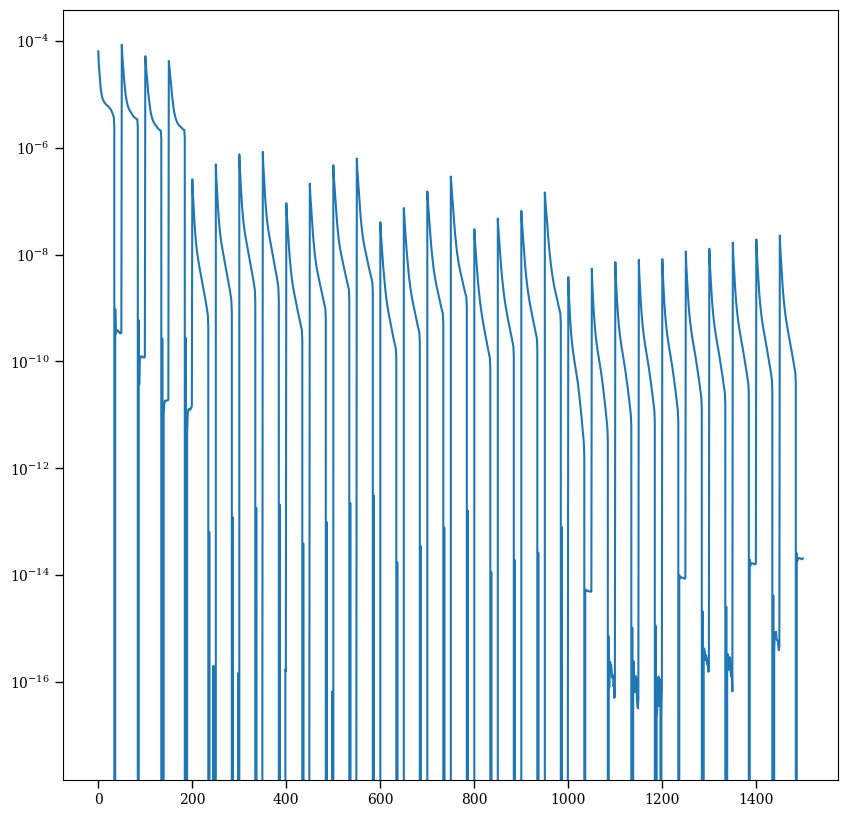

In [6]:
#The output prediction is a concatenation of many different redshift bins (and observables) in general
plt.semilogy(model_pred)
plt.gcf().set_size_inches((10,10))

In [7]:
# The ordering of the predictions is defined by the ordering of the
# obsered data vector, which is stored in the relevant likelihood
likelihood = model.likelihoods['Nx2PTAngularPowerSpectrum']
data_vector = likelihood.observed_data_vector

# spectrum_type specifies what type of spectrum each entry contains
# zbin0 and zbin1 specify the index of the bins of the two fields being correlated
# separation tells us the ell value (generically the radius/wavenumber
# value contains the measured value
print(data_vector.spectra.dtype)

[('spectrum_type', 'S10'), ('zbin0', '<i8'), ('zbin1', '<i8'), ('separation', '<f8'), ('value', '<f8')]


In [90]:
#lets use this information to write a plotting script

def plot_c_kk_vs_model(observed_spectra, model_pred, cov_data, scale_cuts, 
                      use_source_samples, spectrum_info, logy=False, ellcell=True, yscale=50):

    f, ax = plt.subplots(2*len(use_source_samples), len(use_source_samples), sharex=True, 
                         sharey='row', gridspec_kw={'height_ratios': [3, 1]*len(use_source_samples)})
    ell_eff = spectrum_info['c_kk']['separation']
    
    counter = 0
    for ii, i in enumerate(use_source_samples):
        for jj, j in enumerate(use_source_samples):
            if i>j: 
                ax[2*jj][ii].axis('off')
                ax[2*jj+1][ii].axis('off')
                continue
            idx = np.where((observed_spectra['spectrum_type'] == b'c_kk') & (observed_spectra['zbin0'] == i) & (observed_spectra['zbin1'] == j))[0]
            ell_eff_i = spectrum_info['c_kk']['separation']
            
            n_ell = len(ell_eff)
            idxx, idxy = np.meshgrid(idx, idx, indexing='ij')
            cov = np.diag(cov_data['value'][idxx, idxy])
            err = np.sqrt(cov)
            model = model_pred[idx]

            ax[2*jj,ii].errorbar(ell_eff_i,  ell_eff_i**ellcell * observed_spectra['value'][idx], ell_eff_i**ellcell * err, color=f'k', ls='', marker='o', ms=3, capsize=3)        
            ax[2*jj,ii].plot(ell_eff_i,  ell_eff_i**ellcell * model, color=f'k')
            
            ax[2*jj+1,ii].plot(ell_eff_i, (observed_spectra['value'][idx]-model)/err, color=f'k', ls='', marker='o', ms=3)
            ax[2*jj+1,ii].hlines(0, 1, ell_eff[-1], color='k')
            
            ax[2*jj, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_kk'][f'{i}_{j}'][0], color='k', alpha=0.2)
            ax[2*jj, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_kk'][f'{i}_{j}'][1], 3000, color='k', alpha=0.2)
            ax[2*jj+1, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_kk'][f'{i}_{j}'][0], color='k', alpha=0.4)              
            ax[2*jj+1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_kk'][f'{i}_{j}'][0], scale_cuts['c_kk'][f'{i}_{j}'][1], color='k', alpha=0.2)
            ax[2*jj+1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_kk'][f'{i}_{j}'][1], 3000, color='k', alpha=0.4)
            ax[2*jj, ii].set_xlim([25, scale_cuts['c_kk'][f'{i}_{j}'][1]*1.5])
            ax[2*jj, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))

            if ii==0:
                if not ellcell:
                    ax[2*jj,0].set_ylabel(r'$C_{\ell}^{\gamma_{E} \gamma_{E}}$')
                else:
                    ax[2*jj,0].set_ylabel(r'$\ell\,C_{\ell}^{\gamma_{E} \gamma_{E}}$')

            ax[2*jj][0].set_yscale('log')
            ax[2*jj][0].set_ylim([1e-9,5e-6])      
            ax[2*jj+1][0].set_ylim([-3,3])   

        ax[-1,ii].set_xlabel(r'$\ell$')     

    f.subplots_adjust(wspace=0.02, hspace=0.14)
    f.set_figheight(8)
    f.set_figwidth(12)

def plot_c_gg_gk_v_model(observed_spectra, model_pred, cov_data, scale_cuts, 
                         use_lens_samples, use_source_samples, spectrum_info,
                         logy=False, ellcell=False, yscalex=50, yscalea=50):
    
    f, ax = plt.subplots(4, len(use_lens_samples), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]*2})
    sample_names = ['BGS', 'LRG0', 'LRG1', 'LRG2', 'LRG3']
    ell_eff = spectrum_info['c_dk']['separation']
    
    counter = 0
    for ii, i in enumerate(use_lens_samples):
        for jj, j in enumerate(use_source_samples):

            idx = np.where((observed_spectra['spectrum_type'] == b'c_dk') & (observed_spectra['zbin0'] == i) & (observed_spectra['zbin1'] == j))[0]
            ell_eff_i = spectrum_info['c_dk']['separation']
            
            n_ell = len(ell_eff)
            idxx, idxy = np.meshgrid(idx, idx, indexing='ij')
            cov = np.diag(cov_data['value'][idxx, idxy])
            err = np.sqrt(cov)
            model = model_pred[idx]

            ax[0,ii].errorbar(ell_eff_i,  ell_eff_i**ellcell * observed_spectra['value'][idx], ell_eff_i**ellcell * err, color=f'C{jj}', ls='', marker='o', ms=3, capsize=3)        
            ax[0,ii].plot(ell_eff_i,  ell_eff_i**ellcell * model, color=f'C{jj}')
            
            ax[1,ii].plot(ell_eff_i, (observed_spectra['value'][idx]-model)/err, color=f'C{jj}', ls='', marker='o', ms=3)
            ax[1,ii].hlines(0, 1, ell_eff[-1], color='k')
            
            if j==use_source_samples[0]:
                ax[0, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_dk'][f'{i}_{j}'][0], color='k', alpha=0.2)
                ax[0, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_dk'][f'{i}_{j}'][1], 2000, color='k', alpha=0.2)
                ax[1, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_dk'][f'{i}_{j}'][0], color='k', alpha=0.4)              
                ax[1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_dk'][f'{i}_{j}'][0], scale_cuts['c_dk'][f'{i}_{j}'][1], color='k', alpha=0.2)
                ax[1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_dk'][f'{i}_{j}'][1], 2000, color='k', alpha=0.4)
                ax[0, ii].set_xlim([25, scale_cuts['c_dk'][f'{i}_{j}'][1]*1.5])
                ax[0, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))
                
            if i==0:
                if not ellcell:
                    ax[0,ii].set_ylabel(r'$C_{\ell}^{\delta_{g} \gamma_{E}}$')
                else:
                    ax[0,ii].set_ylabel(r'$\ell\,C_{\ell}^{\delta_{g} \gamma_{E}}$')
                    
        idx = np.where((observed_spectra['spectrum_type'] == b'c_dd') & (observed_spectra['zbin0'] == i) & (observed_spectra['zbin1'] == i))[0] 
        ell_eff_i = spectrum_info['c_dd']['separation']

        n_ell = len(ell_eff)
        idxx, idxy = np.meshgrid(idx, idx, indexing='ij')
        cov = np.diag(cov_data['value'][idxx, idxy])
        err = np.sqrt(cov)
        model = model_pred[idx]
        ax[2,ii].errorbar(ell_eff_i, ell_eff_i**ellcell * observed_spectra['value'][idx], ell_eff_i**ellcell * err, color='k', ls='', marker='o', ms=3, capsize=3)        
        ax[2,ii].plot(ell_eff_i, ell_eff_i**ellcell * model, color='k')

        ax[3,ii].plot(ell_eff_i, (observed_spectra['value'][idx]-model)/err, color='k', ls='', marker='o', ms=3)

        ax[3,ii].hlines(0, 1, ell_eff[-1], color='k')
        ax[2, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_dd'][f'{i}_{i}'][0], color='k', alpha=0.2)
        ax[2, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_dd'][f'{i}_{i}'][1], 2000, color='k', alpha=0.2)
        ax[3, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_dd'][f'{i}_{i}'][0], color='k', alpha=0.4)        
        ax[3, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_dd'][f'{i}_{i}'][0], scale_cuts['c_dd'][f'{i}_{i}'][1], color='k', alpha=0.2)
        ax[3, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_dd'][f'{i}_{i}'][1], 2000, color='k', alpha=0.4)
        ax[3, ii].set_xlim([25, scale_cuts['c_dd'][f'{i}_{i}'][1]*1.5])

        if i==0:
            if not ellcell:
                ax[2,ii].set_ylabel(r'$C_{\ell}^{\delta_{g} \delta_{g}}$')    
            else:
                ax[2,ii].set_ylabel(r'$\ell\, C_{\ell}^{\delta_{g} \delta_{g}}$')    
                
        ax[3,ii].set_xlabel(r'$\ell$')            
        
    ax[0][0].set_ylim([1e-9,1e-6])      
    ax[1][0].set_ylim([-3,3])   
    if logy:
        ax[0][0].set_ylim([1e-9,1e-6])      
        ax[0][0].set_yscale('log')
    elif ellcell:
        ax[0][0].set_ylim([-yscalex*1e-7,yscalex*1e-6])              
        ax[2][0].set_ylim([yscalea*1e-6,yscalea*7e-5])      
        
    else:
        ax[0][0].set_ylim([-1e-7,1e-6])      
        ax[2][0].set_ylim([1e-6,7e-5])      
        
    ax[3][0].set_ylim([-3,3])   
    
    if logy:
        ax[2][0].set_yscale('log')
        
    f.subplots_adjust(wspace=0.02, hspace=0.14)
    for ii, i in enumerate(use_lens_samples):
        ax[2][ii].text(0.4, 0.9, sample_names[i], fontsize=12, transform=ax[0][ii].transAxes)
        
    f.set_figheight(8)
    f.set_figwidth(12)


def plot_p_ell_v_model(observed_spectra, model_pred, cov_data, scale_cuts, 
                         use_lens_samples, spectrum_info,
                         logy=False, yscalex=50, yscalea=50,
                         ells=[0,2]):
    
    f, ax = plt.subplots(2, len(use_lens_samples), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
    sample_names = ['BGS', 'LRG0', 'LRG1', 'LRG2', 'LRG3']
    
    counter = 0
    for ii, i in enumerate(use_lens_samples):
        for ell in ells:
            idx = np.where((observed_spectra['spectrum_type'] == b'p_gg_ell') & (observed_spectra['ell'] == ell) & (observed_spectra['zbin0'] == i) & (observed_spectra['zbin1'] == i))[0] 
            k_eff_i = spectrum_info['p_gg_ell']['separation']
    
            n_k = len(k_eff_i)
            idxx, idxy = np.meshgrid(idx, idx, indexing='ij')
            cov = np.diag(cov_data['value'][idxx, idxy])
            err = np.sqrt(cov)
            model = model_pred[idx]
            ax[0,ii].errorbar(k_eff_i, k_eff_i * observed_spectra['value'][idx], k_eff_i * err, color=f'C{ell}', ls='', marker='o', ms=3, capsize=3)        
            ax[0,ii].plot(k_eff_i, k_eff_i * model, color=f'C{ell}')
    
            ax[1,ii].plot(k_eff_i, (observed_spectra['value'][idx]-model)/err, color=f'C{ell}', ls='', marker='o', ms=3)

        ax[1,ii].hlines(0, 0, k_eff_i[-1], color='k')
        ax[0, ii].fill_betweenx(np.linspace(-1000, 2500, 100), 0, scale_cuts['p_gg_ell'][f'{i}_{i}_0'][0], color='k', alpha=0.2)
        ax[0, ii].fill_betweenx(np.linspace(-1000, 2500, 100), scale_cuts['p_gg_ell'][f'{i}_{i}_0'][1], 2000, color='k', alpha=0.2)
        ax[1, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['p_gg_ell'][f'{i}_{i}_0'][0], color='k', alpha=0.4)        
        ax[1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['p_gg_ell'][f'{i}_{i}_0'][0], scale_cuts['p_gg_ell'][f'{i}_{i}_0'][1], color='k', alpha=0.2)
        ax[1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['p_gg_ell'][f'{i}_{i}_0'][1], 2000, color='k', alpha=0.4)
        ax[1, ii].set_xlim([0, scale_cuts['p_gg_ell'][f'{i}_{i}_0'][1]*1.5])

        if i==0:
            ax[0,ii].set_ylabel(r'$k\, P_{\ell}(k)$')    
                
        ax[1,ii].set_xlabel(r'$k\,[h\,\rm Mpc^{-1}]$')            
        
    ax[0][0].set_ylim([-500, 2500])      
    ax[1][0].set_ylim([-3,3])   
    if logy:
#        ax[0][0].set_ylim([1e-9,1e-6])      
        ax[0][0].set_yscale('log')
        
    f.subplots_adjust(wspace=0.02, hspace=0.14)
    for ii, i in enumerate(use_lens_samples):
        ax[0][ii].text(0.4, 0.9, sample_names[i], fontsize=12, transform=ax[0][ii].transAxes)
        
    f.set_figheight(8)
    f.set_figwidth(12)
        


/tmp/ipykernel_767893/206856357.py:38: RuntimeWarning: overflow encountered in exp
  ax[2*jj, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))


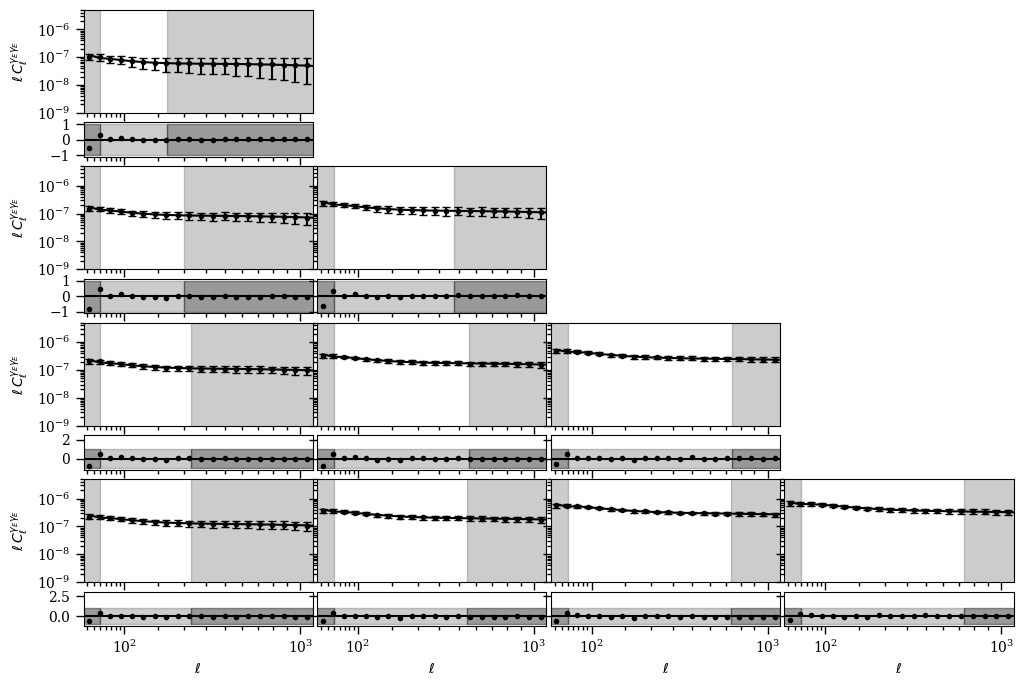

In [9]:
plot_c_kk_vs_model(data_vector.spectra, model_pred, data_vector.cov, data_vector.scale_cuts, 
                   [0,1,2,3], data_vector.spectrum_info)

In [32]:
%pdb

Automatic pdb calling has been turned ON


/tmp/ipykernel_767893/869808685.py:91: RuntimeWarning: overflow encountered in exp
  ax[0, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))


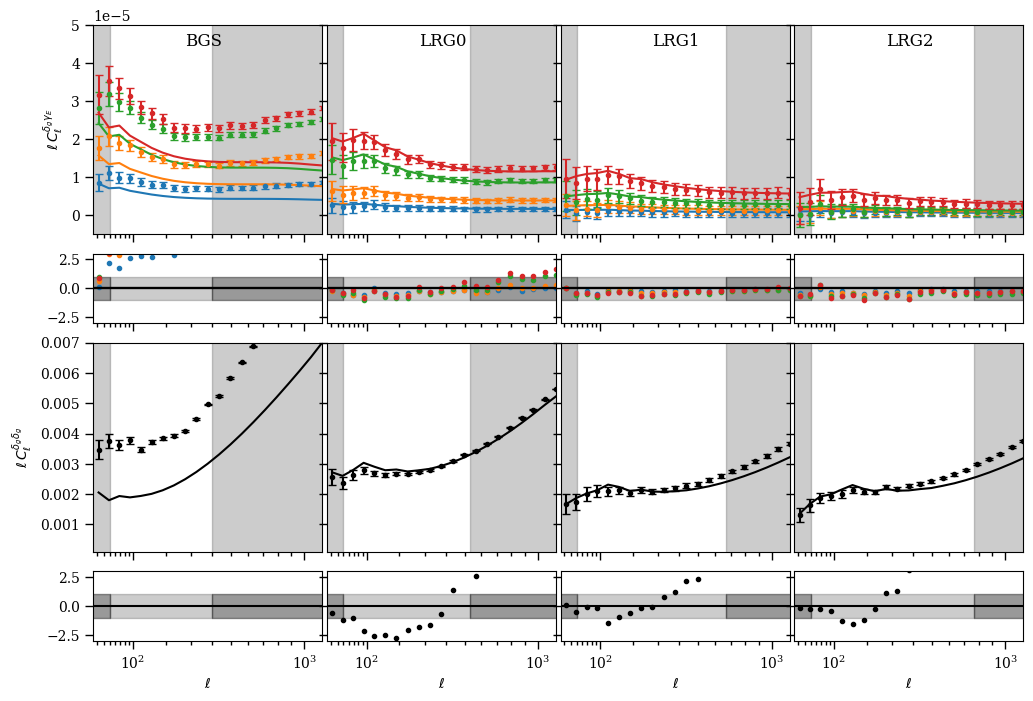

In [50]:
use_lens_samples = [0,1,2,3]
use_source_samples = [0,1,2,3]
plot_c_gg_gk_v_model(data_vector.spectra, model_pred, data_vector.cov, data_vector.scale_cuts, 
                      use_lens_samples, use_source_samples, data_vector.spectrum_info, ellcell=True, yscalea=100)

## Run minimization

In [13]:
import jax
import jaxopt


In [21]:
log_like = jax.jit(lambda p: -model.log_likelihood(p))
solver = jaxopt.LBFGS(fun=log_like)
x0 = model.prior.get_reference_values()
results = solver.run(x0)

2025-09-16 19:47:03.194470: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-09-16 19:48:37.403221: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 3m34.208860209s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-09-16 19:58:48.175441: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_while] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-09-16 20:01:01.749680: E external/xla/xla/service/slow_oper

In [82]:
params_bf = dict(zip(model.prior.params, results.params))
ndv = len(model.likelihoods['Nx2PTAngularPowerSpectrum'].observed_data_vector.scale_mask) + len(model.likelihoods['RSDPK'].observed_data_vector.scale_mask)
print('best fit chi^2, d_dv, n_pars:', 2*results.state.value, ndv, len(model.prior.params))

best fit chi^2, d_dv, n_pars: 128.25021 490 78


In [39]:
params_bf = dict(zip(model.prior.params, results.params))
model_proj = model.predict_model('Nx2PTAngularPowerSpectrum', params_bf, apply_scale_mask=False)
model_pk = model.predict_model('RSDPK', params_bf, apply_scale_mask=False)

In [65]:
likelihood = model.likelihoods['Nx2PTAngularPowerSpectrum']
data_vector = likelihood.observed_data_vector

/tmp/ipykernel_767893/2045390303.py:38: RuntimeWarning: overflow encountered in exp
  ax[2*jj, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))


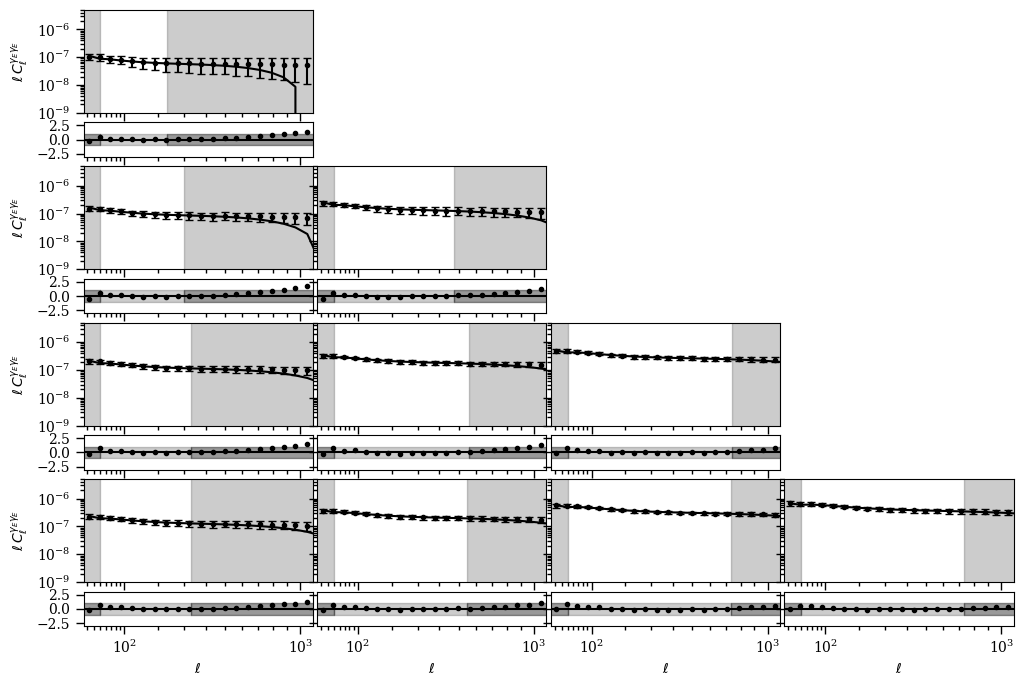

In [66]:
plot_c_kk_vs_model(data_vector.spectra, model_proj, data_vector.cov, data_vector.scale_cuts, 
                   [0,1,2,3], data_vector.spectrum_info)

/tmp/ipykernel_767893/2045390303.py:90: RuntimeWarning: overflow encountered in exp
  ax[0, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))


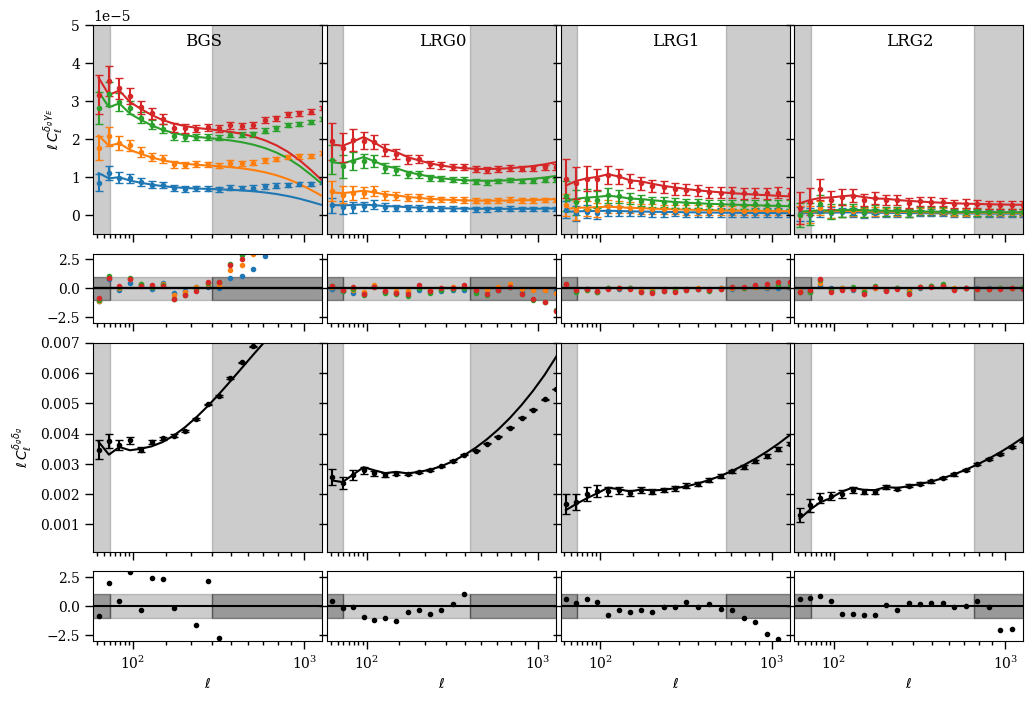

In [67]:
plot_c_gg_gk_v_model(data_vector.spectra, model_proj, data_vector.cov, data_vector.scale_cuts, 
                    [0,1,2,3], [0,1,2,3], data_vector.spectrum_info, ellcell=True, yscalea=100)

In [68]:
likelihood = model.likelihoods['RSDPK']
data_vector = likelihood.observed_data_vector

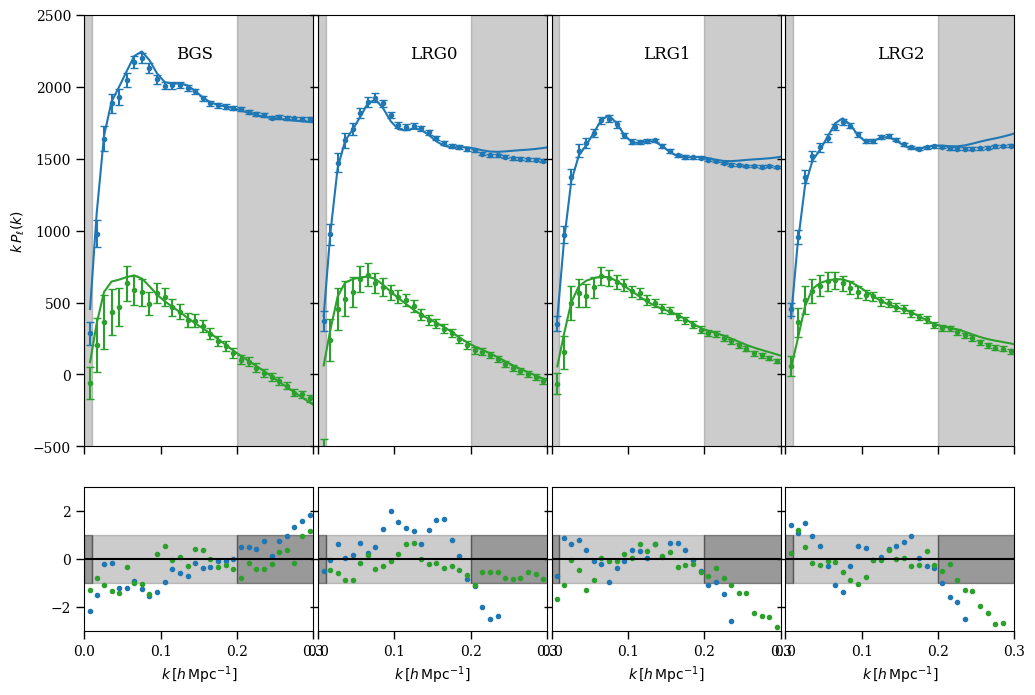

In [91]:
plot_p_ell_v_model(data_vector.spectra, model_pk, data_vector.cov, data_vector.scale_cuts, 
                         [0,1,2,3], data_vector.spectrum_info)